# Piperazine Ring Conformation using RDKit
> Examine ring conformation of piperazine built by RDKit ETKDG algorithm

- toc: true 
- badges: true
- comments: true
- categories: [rdkit]

# Motivation

I noticed whenever I built 3D conformers of molecules containing piperazine (or cyclohexane) using RDKit, I tend to get a distorted ring conformation. RDKit's ETKDG (Experimental Torsion angle Knowledge-based Distance Geometry) algorithm works really well in general, but, in this case, it was not doing a good job at coming up with a reasonable initial conformation. I wanted to first quantify how much chair vs boat vs twisted conformer I get, so either I could use it to filter out non-desirable conformers or improve the RDKit's conformer generation routine. 

In [246]:
#collapse-hide
%matplotlib inline
import matplotlib.pyplot as plt

from io import BytesIO
import pandas as pd
import numpy as np
from rdkit.Chem import PandasTools

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdRGroupDecomposition

from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults

DrawingOptions.bondLineWidth=1.8
IPythonConsole.ipython_useSVG=True
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')
import rdkit
import py3Dmol
print(rdkit.__version__)

2020.03.2


# Ring conformation using ETKDG v1

Let's make a piperazine molecule for testing. I put atom map in my SMILES, so I can refer them easily later.

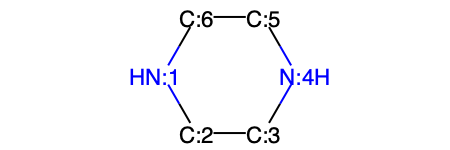

In [315]:
smiles = '[NH:4]1[CH2:3][CH2:2][NH:1][CH2:6][CH2:5]1'
mol = Chem.MolFromSmiles(smiles)
mol

Let's use default parameter for embedding, which uses ETKDG version 1, and generate 500 conformers. 

In [316]:
# ETKDG v1 
params = Chem.rdDistGeom.EmbedParameters()
params.randomSeed = 0xf00d

#params = Chem.rdDistGeom.srETKDGv3() 
cids = AllChem.EmbedMultipleConfs(mol, numConfs=500, params=params)

In [317]:
# atom mapping
atoms = {a.GetAtomMapNum(): a.GetIdx() for a in mol.GetAtoms() if a.GetAtomMapNum() > 0}

# torsion angle atom indices
torsions = [
    (atoms[1], atoms[2], atoms[3], atoms[4]),
    (atoms[2], atoms[3], atoms[4], atoms[5]),
    (atoms[3], atoms[4], atoms[5], atoms[6]),
    (atoms[4], atoms[5], atoms[6], atoms[1]),
    (atoms[5], atoms[6], atoms[1], atoms[2]),
    (atoms[6], atoms[1], atoms[2], atoms[3]),
]

I'm going to define a simple check in chain vs boat vs twisted conformers of cyclohexane ring. If all six torsions are near +/- 60˚ (margin 30˚), it is considered a chair conformation. If two opposite torsions are close to 0˚ (margin 30˚) and the other remaining torsion angles are around +/- 60˚, then it is considered a boat conformation. The rest are considered as a twisted conformation.

In [318]:
def ring_conformers(mol):
    angles = []
    confs = []

    for conf in mol.GetConformers():
        angs = np.abs([Chem.rdMolTransforms.GetDihedralDeg(conf, *t) for t in torsions])
        angles.append(angs)

        if np.all(np.abs((angs - 60)/60) < 0.5): 
            confs.append('chair')
        elif angs[0] < 30 and angs[3] < 30 and np.all(np.abs((angs[[1,3,4,5]] - 60)/60) < 0.5):
            confs.append('boat')
        elif angs[1] < 30 and angs[4] < 30 and np.all(np.abs((angs[[0,2,3,4]] - 60)/60) < 0.5):
            confs.append('boat')        
        elif angs[2] < 30 and angs[5] < 30 and np.all(np.abs((angs[[0,1,3,4]] - 60)/60) < 0.5):
            confs.append('boat')        
        else:
            confs.append('twisted')
    return confs

In [319]:
from collections import Counter
confs = ring_conformers(mol)
Counter(confs)

Counter({'chair': 144, 'twisted': 327, 'boat': 29})

So, I got 144 chair (28%), 29 boat (6%), and 327 twisted (65%) conformers. Let's take a look at some conformers and make sure we got the right conformers. First chair conformation.

In [320]:
#collapse-hide
from random import shuffle
conf_idx = [i for i, c in enumerate(confs) if c == 'chair']
shuffle(conf_idx)

viewer = py3Dmol.view(width=300, height=300)
viewer.addModel(Chem.MolToMolBlock(mol, confId=conf_idx[0]), 'mol')
viewer.setStyle({"stick":{}})
viewer.zoomTo()
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

And a boat conformation:

In [321]:
#collapse-hide
from random import shuffle
conf_idx = [i for i, c in enumerate(confs) if c == 'boat']
shuffle(conf_idx)

viewer = py3Dmol.view(width=300, height=300)
viewer.addModel(Chem.MolToMolBlock(mol, confId=conf_idx[0]), 'mol')
viewer.setStyle({"stick":{}})
viewer.zoomTo()
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

And finally a twisted conformation:

In [322]:
#collapse-hide
from random import shuffle
conf_idx = [i for i, c in enumerate(confs) if c == 'twisted']
shuffle(conf_idx)

viewer = py3Dmol.view(width=300, height=300)
viewer.addModel(Chem.MolToMolBlock(mol, confId=conf_idx[0]), 'mol')
viewer.setStyle({"stick":{}})
viewer.zoomTo()
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Optimize Geometry using MMFF

Optimizing the Geometry using MMFF does the number of chair conformations and reduces twisted conformers.

In [323]:
for conf in mol.GetConformers():
    AllChem.MMFFOptimizeMolecule(mol, confId=conf.GetId())

In [325]:
confs = ring_conformers(mol)
Counter(confs)

Counter({'chair': 253, 'twisted': 247})

Still about 50% of the conformers remain in the twisted conformation. 

In [326]:
#collapse-hide
from random import shuffle
conf_idx = [i for i, c in enumerate(confs) if c == 'twisted']
shuffle(conf_idx)

viewer = py3Dmol.view(width=300, height=300)
viewer.addModel(Chem.MolToMolBlock(mol, confId=conf_idx[0]), 'mol')
viewer.setStyle({"stick":{}})
viewer.zoomTo()
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# ETKDG version 3

I commented this issue on Greg's blog and was suggested to try ETKDG version 3 algorithm [https://pubs.acs.org/doi/abs/10.1021/acs.jcim.0c00025](ref). Here's the result.  

In [332]:
# ETKDG v3
params = Chem.rdDistGeom.srETKDGv3() 
params.randomSeed = 0xf00d

cids = AllChem.EmbedMultipleConfs(mol, numConfs=500, params=params)

In [333]:
confs = ring_conformers(mol)
Counter(confs)

Counter({'chair': 222, 'twisted': 195, 'boat': 83})

In [334]:
for conf in mol.GetConformers():
    AllChem.MMFFOptimizeMolecule(mol, confId=conf.GetId())

In [335]:
confs = ring_conformers(mol)
Counter(confs)

Counter({'chair': 267, 'twisted': 233})

So, I got 222 chair (44%), 83 boat (16%), and 195 twisted (39%) conformers with just ETKDGv3 algorithm, but MMFF optimization slightly improved chair conformations. However, optimization also increased twisted conformations.

# Conclusion

I have used piperazine as an example because the molecule I was working had one, but I imagine cyclohexane may have the similar issue. The new ETKDG v3 algorithm does a good job getting chair conformation without FF optimization, but I wish I could get chair conformation most of the time. I have not looked into how RDKit's ETKDG algorithm is implemented yet. If it is simple, I might be able to contribute. Otherwise, I can use the conformation checker I used here to filter out non-chair conformers.